# LightAutoML installation

In [1]:
!pip install --no-index -U --find-links=/kaggle/input/lightautoml-038-dependecies lightautoml==0.3.8
!pip install --no-index -U --find-links=/kaggle/input/lightautoml-038-dependecies pandas==2.0.3

Looking in links: /kaggle/input/lightautoml-038-dependecies
Processing /kaggle/input/lightautoml-038-dependecies/lightautoml-0.3.8-py3-none-any.whl
Processing /kaggle/input/lightautoml-038-dependecies/AutoWoE-1.3.2-py3-none-any.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/cmaes-0.10.0-py3-none-any.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/joblib-1.2.0-py3-none-any.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/json2html-1.3.0.tar.gz (from lightautoml==0.3.8)
  Preparing metadata (setup.py) ... - \ done
Processing /kaggle/input/lightautoml-038-dependecies/lightgbm-3.2.1-py3-none-manylinux1_x86_64.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/poetry_core-1.8.1-py3-none-any.whl (from lig

In [2]:
%matplotlib inline
import gc
import numpy as np
import pandas as pd
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import torch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## Load Data

In [3]:
INPUT_DIR = '../input/linking-writing-processes-to-writing-quality'
train_logs = pd.read_csv(f'{INPUT_DIR}/train_logs.csv')
train_scores = pd.read_csv(f'{INPUT_DIR}/train_scores.csv')
test_logs = pd.read_csv(f'{INPUT_DIR}/test_logs.csv')
ss_df = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')

In [4]:
train_essays = pd.read_csv('../input/writing-quality-challenge-constructed-essays/train_essays_02.csv')
train_essays.index = train_essays["Unnamed: 0"]
train_essays.index.name = None
train_essays.drop(columns=["Unnamed: 0"], inplace=True)
train_essays.head()

,essay
001519c8,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...
0022f953,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq..."
0042269b,qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...
0059420b,qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...
0075873a,"qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq..."


## Feature Engineering

In [5]:
# Function to construct essays copied from here (small adjustments): https://www.kaggle.com/code/kawaiicoderuwu/essay-contructor

def getEssays(df):
    textInputDf = df[['id', 'activity', 'cursor_position', 'text_change']]
    textInputDf = textInputDf[textInputDf.activity != 'Nonproduction']
    valCountsArr = textInputDf['id'].value_counts(sort=False).values
    lastIndex = 0
    essaySeries = pd.Series()
    for index, valCount in enumerate(valCountsArr):
        currTextInput = textInputDf[['activity', 'cursor_position', 'text_change']].iloc[lastIndex : lastIndex + valCount]
        lastIndex += valCount
        essayText = ""
        for Input in currTextInput.values:
            if Input[0] == 'Replace':
                replaceTxt = Input[2].split(' => ')
                essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] +\
                essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
                continue
            if Input[0] == 'Paste':
                essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
                continue
            if Input[0] == 'Remove/Cut':
                essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
                continue
            if "M" in Input[0]:
                croppedTxt = Input[0][10:]
                splitTxt = croppedTxt.split(' To ')
                valueArr = [item.split(', ') for item in splitTxt]
                moveData = (int(valueArr[0][0][1:]), 
                            int(valueArr[0][1][:-1]), 
                            int(valueArr[1][0][1:]), 
                            int(valueArr[1][1][:-1]))
                if moveData[0] != moveData[2]:
                    if moveData[0] < moveData[2]:
                        essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] +\
                        essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                    else:
                        essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] +\
                        essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
                continue
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
        essaySeries[index] = essayText
    essaySeries.index =  textInputDf['id'].unique()
    return pd.DataFrame(essaySeries, columns=['essay'])

In [6]:
# Helper functions

def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

In [7]:
AGGREGATIONS = ['count', 'mean', 'std', 'min', 'max', 'first', 'last', 'sem', q1, 'median', q3, 'skew', pd.DataFrame.kurt, 'sum']

def split_essays_into_sentences(df):
    essay_df = df
    essay_df['id'] = essay_df.index
    essay_df['sent'] = essay_df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    essay_df = essay_df.explode('sent')
    essay_df['sent'] = essay_df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    essay_df['sent_len'] = essay_df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    essay_df['sent_word_count'] = essay_df['sent'].apply(lambda x: len(x.split(' ')))
    essay_df = essay_df[essay_df.sent_len!=0].reset_index(drop=True)
    return essay_df

def compute_sentence_aggregations(df):
    sent_agg_df = pd.concat(
        [df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    )
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df

def split_essays_into_paragraphs(df):
    essay_df = df
    essay_df['id'] = essay_df.index
    essay_df['paragraph'] = essay_df['essay'].apply(lambda x: x.split('\n'))
    essay_df = essay_df.explode('paragraph')
    # Number of characters in paragraphs
    essay_df['paragraph_len'] = essay_df['paragraph'].apply(lambda x: len(x)) 
    # Number of words in paragraphs
    essay_df['paragraph_word_count'] = essay_df['paragraph'].apply(lambda x: len(x.split(' ')))
    essay_df = essay_df[essay_df.paragraph_len!=0].reset_index(drop=True)
    return essay_df

def compute_paragraph_aggregations(df):
    paragraph_agg_df = pd.concat(
        [df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    ) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

In [8]:
# Sentence features for train dataset
train_sent_df = split_essays_into_sentences(train_essays)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)
# plt.figure(figsize=(15, 1.5))
# plt.boxplot(x=train_sent_df.sent_len, vert=False, labels=['Sentence length'])
# plt.show()

In [9]:
# Paragraph features for train dataset
train_paragraph_df = split_essays_into_paragraphs(train_essays)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)
# plt.figure(figsize=(15, 1.5))
# plt.boxplot(x=train_paragraph_df.paragraph_len, vert=False, labels=['Paragraph length'])
# plt.show()

In [10]:
# Features for test dataset
test_essays = getEssays(test_logs)
test_sent_agg_df = compute_sentence_aggregations(split_essays_into_sentences(test_essays))
test_paragraph_agg_df = compute_paragraph_aggregations(split_essays_into_paragraphs(test_essays))

In [11]:
# The following code comes almost Abdullah's notebook: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
# Abdullah's code is based on work shared in previous notebooks (e.g., https://www.kaggle.com/code/hengzheng/link-writing-simple-lgbm-baseline)

from collections import defaultdict

class Preprocessor:
    
    def __init__(self, seed):
        self.seed = seed
        
        self.activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
        self.events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 
              'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
        self.text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]
        
        self.idf = defaultdict(float)
    
    def activity_counts(self, df):
        tmp_df = df.groupby('id').agg({'activity': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['activity'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'activity_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def event_counts(self, df, colname):
        tmp_df = df.groupby('id').agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def text_change_counts(self, df):
        tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['text_change'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf
            
        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['down_event'].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[(~df['text_change'].str.contains('=>'))&(df['text_change'] != 'NoChange')].reset_index(drop=True)
        tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
        tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
        tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop(['text_change'], axis=1, inplace=True)
        return tmp_df
    
    def make_feats(self, df):
        
        feats = pd.DataFrame({'id': df['id'].unique().tolist()})
        
        print("Engineering time data")
        for gap in self.gaps:
            df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
            df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
        df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering cursor position data")
        for gap in self.gaps:
            df[f'cursor_position_shift{gap}'] = df.groupby('id')['cursor_position'].shift(gap)
            df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[f'cursor_position_shift{gap}']
            df[f'cursor_position_abs_change{gap}'] = np.abs(df[f'cursor_position_change{gap}'])
        df.drop(columns=[f'cursor_position_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering word count data")
        for gap in self.gaps:
            df[f'word_count_shift{gap}'] = df.groupby('id')['word_count'].shift(gap)
            df[f'word_count_change{gap}'] = df['word_count'] - df[f'word_count_shift{gap}']
            df[f'word_count_abs_change{gap}'] = np.abs(df[f'word_count_change{gap}'])
        df.drop(columns=[f'word_count_shift{gap}' for gap in self.gaps], inplace=True)
        
        print("Engineering statistical summaries for features")
        feats_stat = [
            ('event_id', ['max']),
            ('up_time', ['max']),
            ('action_time', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
            ('activity', ['nunique']),
            ('down_event', ['nunique']),
            ('up_event', ['nunique']),
            ('text_change', ['nunique']),
            ('cursor_position', ['nunique', 'max', 'quantile', 'sem', 'mean']),
            ('word_count', ['nunique', 'max', 'quantile', 'sem', 'mean'])]
        for gap in self.gaps:
            feats_stat.extend([
                (f'action_time_gap{gap}', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'cursor_position_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'word_count_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt])
            ])
        
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method_name}'})
                feats = feats.merge(tmp_df, on='id', how='left')

        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering event counts data")
        tmp_df = self.event_counts(df, 'down_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, 'up_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on='id', how='left')

        print("Engineering ratios data")
        feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
        feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
        feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
        feats['idle_time_ratio'] = feats['action_time_gap1_sum'] / feats['up_time_max']

        return feats

In [12]:
preprocessor = Preprocessor(seed=42)
train_feats = preprocessor.make_feats(train_logs)
test_feats = preprocessor.make_feats(test_logs)
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
train_feats = train_feats.drop(columns=nan_cols)
test_feats = test_feats.drop(columns=nan_cols)

Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [04:14<00:00,  7.71s/it, column=word_count_change100, method=kurt]


Engineering activity counts data


100%|██████████| 2471/2471 [00:00<00:00, 5870.14it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 2471/2471 [00:00<00:00, 5646.50it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 2471/2471 [00:00<00:00, 5572.50it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 2471/2471 [00:00<00:00, 5320.99it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 2471/2471 [00:00<00:00, 5472.75it/s]


Engineering input words data


/tmp/ipykernel_26/3946551957.py:221: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
/tmp/ipykernel_26/3946551957.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
/tmp/ipykernel_26/3946551957.py:223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

Engineering ratios data
Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [00:01<00:00, 20.46it/s, column=word_count_change100, method=kurt]


Engineering activity counts data


100%|██████████| 3/3 [00:00<00:00, 28339.89it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 3/3 [00:00<00:00, 21509.25it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 3/3 [00:00<00:00, 25997.75it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 3/3 [00:00<00:00, 22712.84it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 3/3 [00:00<00:00, 24291.34it/s]
/tmp/ipykernel_26/3946551957.py:221: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
/tmp/ipykernel_26/3946551957.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
/tmp/ipykernel_26/3946551957.py:223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

Engineering input words data
Engineering ratios data


In [13]:
# Code for additional aggregations comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs

train_agg_fe_df = train_logs.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
train_agg_fe_df.columns = ['_'.join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

test_agg_fe_df = test_logs.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
test_agg_fe_df.columns = ['_'.join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

train_feats = train_feats.merge(train_agg_fe_df, on='id', how='left')
test_feats = test_feats.merge(test_agg_fe_df, on='id', how='left')

In [14]:
# Code for creating these features comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
# Idea is based on features introduced in Section 3 of this research paper: https://files.eric.ed.gov/fulltext/ED592674.pdf

data = []

for logs in [train_logs, test_logs]:
    logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
    logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000

    group = logs.groupby('id')['time_diff']
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby('id')['down_time'].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(pd.DataFrame({
        'id': logs['id'].unique(),
        'largest_lantency': largest_lantency,
        'smallest_lantency': smallest_lantency,
        'median_lantency': median_lantency,
        'initial_pause': initial_pause,
        'pauses_half_sec': pauses_half_sec,
        'pauses_1_sec': pauses_1_sec,
        'pauses_1_half_sec': pauses_1_half_sec,
        'pauses_2_sec': pauses_2_sec,
        'pauses_3_sec': pauses_3_sec,
    }).reset_index(drop=True))

train_eD592674, test_eD592674 = data

train_feats = train_feats.merge(train_eD592674, on='id', how='left')
test_feats = test_feats.merge(test_eD592674, on='id', how='left')
train_feats = train_feats.merge(train_scores, on='id', how='left')

In [15]:
# Adding the additional features to the original feature set

train_feats = train_feats.merge(train_sent_agg_df, on='id', how='left')
train_feats = train_feats.merge(train_paragraph_agg_df, on='id', how='left')
test_feats = test_feats.merge(test_sent_agg_df, on='id', how='left')
test_feats = test_feats.merge(test_paragraph_agg_df, on='id', how='left')

In [16]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [17]:
len(test_feats)

3

# LightGBM train and predict

In [18]:
OOF_PREDS = np.zeros((len(train_feats), 2))
TEST_PREDS = np.zeros((len(test_feats), 2))

In [19]:
# Code comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs

models_dict = {}
scores = []

test_predict_list = []
best_params = {'reg_alpha': 0.007678095440286993, 
               'reg_lambda': 0.34230534302168353, 
               'colsample_bytree': 0.627061253588415, 
               'subsample': 0.854942238828458, 
               'learning_rate': 0.04,   #0.038697981947473245, 
               'num_leaves': 22, 
               'max_depth': 37, 
               'min_child_samples': 18,
               'n_jobs':4
              }

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
        params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 12001,
            "verbosity": -1,
            **best_params
        }
        model = lgb.LGBMRegressor(**params)
        early_stopping_callback = lgb.early_stopping(100, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback],
        )
        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict
        OOF_PREDS[valid_idx, 0] += valid_predict / 5
        test_predict = model.predict(X_test)
        TEST_PREDS[:, 0] += test_predict / 5 / 10
        test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)

[1]	valid_0's rmse: 0.994979
[2]	valid_0's rmse: 0.971753
[3]	valid_0's rmse: 0.95105
[4]	valid_0's rmse: 0.931631
[5]	valid_0's rmse: 0.912679
[6]	valid_0's rmse: 0.895416
[7]	valid_0's rmse: 0.878517
[8]	valid_0's rmse: 0.862567
[9]	valid_0's rmse: 0.846738
[10]	valid_0's rmse: 0.833044
[11]	valid_0's rmse: 0.819773
[12]	valid_0's rmse: 0.806434
[13]	valid_0's rmse: 0.794328
[14]	valid_0's rmse: 0.782885
[15]	valid_0's rmse: 0.772237
[16]	valid_0's rmse: 0.76151
[17]	valid_0's rmse: 0.752921
[18]	valid_0's rmse: 0.745096
[19]	valid_0's rmse: 0.735623
[20]	valid_0's rmse: 0.727965
[21]	valid_0's rmse: 0.721605
[22]	valid_0's rmse: 0.713883
[23]	valid_0's rmse: 0.708105
[24]	valid_0's rmse: 0.702485
[25]	valid_0's rmse: 0.696428
[26]	valid_0's rmse: 0.690825
[27]	valid_0's rmse: 0.685159
[28]	valid_0's rmse: 0.680592
[29]	valid_0's rmse: 0.675816
[30]	valid_0's rmse: 0.671763
[31]	valid_0's rmse: 0.667913
[32]	valid_0's rmse: 0.663912
[33]	valid_0's rmse: 0.66007
[34]	valid_0's rmse: 0

In [20]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   OOF_PREDS[:, 0], 
                                                                   squared=False)))

OOF metric LGBM = 0.61522


# LightAutoML NN (DenseLight) prediction

In [21]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import joblib

# def use_plr(USE_PLR):
#     if USE_PLR:
#         return "plr"
#     else:
#         return "cont"

In [22]:
for i in range(3):
    oof_pred, automl = joblib.load('/kaggle/input/linkinglamamodels/oof_and_lama_denselight_{}.pkl'.format(i))
    OOF_PREDS[:, 1] += oof_pred / 3
    TEST_PREDS[:, 1] += automl.predict(test_feats[train_cols]).data[:, 0] / 3

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your o

In [23]:
print('OOF metric LightAutoML_NN = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                               OOF_PREDS[:, 1], 
                                                                               squared=False)))

OOF metric LightAutoML_NN = 0.61386


# Blending

In [24]:
best_sc = 1
for w in np.arange(0, 1.01, 0.001):
    sc = metrics.mean_squared_error(train_feats[target_col], 
                                    w * OOF_PREDS[:, 0] + (1-w) * OOF_PREDS[:, 1], 
                                    squared=False)
    if sc < best_sc:
        best_sc = sc
        best_w = w
        
print('Composition OOF score = {:.5f}'.format(best_sc))
print('Composition best W = {:.3f}'.format(best_w))

Composition OOF score = 0.60851
Composition best W = 0.472


# Submission creation

In [25]:
W = [best_w, 1 - best_w]
print(W)
test_preds = TEST_PREDS[:, 0] * W[0] + TEST_PREDS[:, 1] * W[1]
test_preds

[0.47200000000000003, 0.528]


array([1.66823222, 0.99674629, 0.95888982])

In [26]:
test_feats['score'] = test_preds
sub1 = test_feats[['id', 'score']]
#test_feats[['id', 'score']].to_csv("submission.csv", index=False)

/tmp/ipykernel_26/1024135510.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_feats['score'] = test_preds


In [27]:
sub1

,id,score
0,0000aaaa,1.668232
1,2222bbbb,0.996746
2,4444cccc,0.958890


# Saving OOFs and test predictions

In [28]:
joblib.dump((OOF_PREDS, TEST_PREDS), 'OOF_and_TEST_preds.pkl')

['OOF_and_TEST_preds.pkl']

# Public LGBM

In [29]:
import warnings
warnings.filterwarnings('ignore')
import gc
import ctypes
def clean_memory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()
clean_memory()

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
%matplotlib inline
import gc
import os
import itertools
import pickle

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
from transformers import BertTokenizer
import warnings

import os
import gc
import re
import random
from collections import Counter, defaultdict
import pprint
import time
import copy


import seaborn as sns
from tqdm.autonotebook import tqdm

# from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder, PowerTransformer, RobustScaler, FunctionTransformer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna

In [31]:
traindf = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
train_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')
testdf = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')

In [32]:
def getEssays(df):
    # Copy required columns
    textInputDf = df[['id', 'activity', 'cursor_position', 'text_change']].copy()
    
    # Get rid of text inputs that make no change
    # Note: Shift was unpreditcable so ignored
    textInputDf = textInputDf[textInputDf.activity != 'Nonproduction']

    # Get how much each Id there is
    valCountsArr = textInputDf['id'].value_counts(sort=False).values

    # Holds the final index of the previous Id
    lastIndex = 0

    # Holds all the essays
    essaySeries = pd.Series()

    # Fills essay series with essays
    for index, valCount in enumerate(valCountsArr):

        # Indexes down_time at current Id
        currTextInput = textInputDf[['activity', 'cursor_position', 'text_change']].iloc[lastIndex : lastIndex + valCount]

        # Update the last index
        lastIndex += valCount

        # Where the essay content will be stored
        essayText = ""

        
        # Produces the essay
        for Input in currTextInput.values:
            
            # Input[0] = activity
            # Input[2] = cursor_position
            # Input[3] = text_change
            
            # If activity = Replace
            if Input[0] == 'Replace':
                # splits text_change at ' => '
                replaceTxt = Input[2].split(' => ')
                
                # DONT TOUCH
                essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
                continue

                
            # If activity = Paste    
            if Input[0] == 'Paste':
                # DONT TOUCH
                essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
                continue

                
            # If activity = Remove/Cut
            if Input[0] == 'Remove/Cut':
                # DONT TOUCH
                essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
                continue

                
            # If activity = Move...
            if "M" in Input[0]:
                # Gets rid of the "Move from to" text
                croppedTxt = Input[0][10:]
                
                # Splits cropped text by ' To '
                splitTxt = croppedTxt.split(' To ')
                
                # Splits split text again by ', ' for each item
                valueArr = [item.split(', ') for item in splitTxt]
                
                # Move from [2, 4] To [5, 7] = (2, 4, 5, 7)
                moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))

                # Skip if someone manages to activiate this by moving to same place
                if moveData[0] != moveData[2]:
                    # Check if they move text forward in essay (they are different)
                    if moveData[0] < moveData[2]:
                        # DONT TOUCH
                        essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                    else:
                        # DONT TOUCH
                        essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
                continue
                
                
            # If just input
            # DONT TOUCH
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]

            
        # Sets essay at index  
        essaySeries[index] = essayText
     
    
    # Sets essay series index to the ids
    essaySeries.index =  textInputDf['id'].unique()
    
    
    # Returns the essay series
    return essaySeries

In [33]:
%%time
train_essays = getEssays(traindf)

CPU times: user 7min 15s, sys: 2min 58s, total: 10min 13s
Wall time: 10min 13s


In [34]:
test_essays = getEssays(testdf)

In [35]:
train_essaysdf = pd.DataFrame({'id': train_essays.index, 'essay': train_essays.values})
test_essaysdf = pd.DataFrame({'id': test_essays.index, 'essay': test_essays.values})

In [36]:
merged_data = train_essaysdf.merge(train_scores, on='id')

In [37]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
X_tokenizer_train = count_vectorizer.fit_transform(merged_data['essay'])
X_tokenizer_test = count_vectorizer.transform(test_essaysdf['essay'])
count_vectorizer.get_feature_names_out() #ADDED
y = merged_data['score']

In [38]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [39]:
X_tokenizer_train = X_tokenizer_train.todense()
X_tokenizer_test = X_tokenizer_test.todense()

In [40]:
for i in range(X_tokenizer_train.shape[1]) : 
    L = list(X_tokenizer_train[:,i])
    li = [int(x) for x in L ]
    df_train[f'feature {i}'] = li

In [41]:
for i in range(X_tokenizer_test.shape[1]) : 
    L = list(X_tokenizer_test[:,i])
    li = [int(x) for x in L ]
    df_test[f'feature {i}'] = li

In [42]:
df_train_index = train_essaysdf['id']
df_test_index = test_essaysdf['id']

In [43]:
df_train.loc[:, 'id'] = df_train_index
df_test.loc[:, 'id'] = df_test_index

In [44]:
train_agg_fe_df = traindf.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
train_agg_fe_df.columns = ['_'.join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

In [45]:
test_agg_fe_df = testdf.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
test_agg_fe_df.columns = ['_'.join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

In [46]:
from collections import defaultdict

class Preprocessor:
    
    def __init__(self, seed):
        self.seed = seed
        
        self.activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
        self.events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 
              'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
        self.text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]
        
        self.idf = defaultdict(float)
#         self.gaps = [1, 2]
    
    def activity_counts(self, df):
        tmp_df = df.groupby('id').agg({'activity': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['activity'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'activity_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret


    def event_counts(self, df, colname):
        tmp_df = df.groupby('id').agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret


    def text_change_counts(self, df):
        tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['text_change'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf
            
        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['down_event'].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
        return ret


    def get_input_words(self, df):
        tmp_df = df[(~df['text_change'].str.contains('=>'))&(df['text_change'] != 'NoChange')].reset_index(drop=True)
        tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
        tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
        tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop(['text_change'], axis=1, inplace=True)
        return tmp_df
    
    def make_feats(self, df):
        
        print("Starting to engineer features")
        
        # initialize features dataframe
        feats = pd.DataFrame({'id': df['id'].unique().tolist()})
        
        # get shifted features
        # time shift
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
            df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
        df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)

        # cursor position shift
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f'cursor_position_shift{gap}'] = df.groupby('id')['cursor_position'].shift(gap)
            df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[f'cursor_position_shift{gap}']
            df[f'cursor_position_abs_change{gap}'] = np.abs(df[f'cursor_position_change{gap}'])
        df.drop(columns=[f'cursor_position_shift{gap}' for gap in self.gaps], inplace=True)

        # word count shift
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f'word_count_shift{gap}'] = df.groupby('id')['word_count'].shift(gap)
            df[f'word_count_change{gap}'] = df['word_count'] - df[f'word_count_shift{gap}']
            df[f'word_count_abs_change{gap}'] = np.abs(df[f'word_count_change{gap}'])
        df.drop(columns=[f'word_count_shift{gap}' for gap in self.gaps], inplace=True)
        
        # get aggregate statistical features
        print("Engineering statistical summaries for features")
        # [(feature name, [ stat summaries to add ])]
        feats_stat = [
            ('event_id', ['max']),
            ('up_time', ['max']),
            ('action_time', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
            ('activity', ['nunique']),
            ('down_event', ['nunique']),
            ('up_event', ['nunique']),
            ('text_change', ['nunique']),
            ('cursor_position', ['nunique', 'max', 'quantile', 'sem', 'mean']),
            ('word_count', ['nunique', 'max', 'quantile', 'sem', 'mean'])]
        for gap in self.gaps:
            feats_stat.extend([
                (f'action_time_gap{gap}', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'cursor_position_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'word_count_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt])
            ])
        
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                    
                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method_name}'})
                feats = feats.merge(tmp_df, on='id', how='left')

        # counts
        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering event counts data")
        tmp_df = self.event_counts(df, 'down_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, 'up_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # input words
        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on='id', how='left')

        # compare feats
        print("Engineering ratios data")
        feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
        feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
        feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
        feats['idle_time_ratio'] = feats['action_time_gap1_sum'] / feats['up_time_max']
        
        print("Done!")
        return feats

In [47]:
preprocessor = Preprocessor(seed=42)

print("Engineering features for training data")

other_train_feats = preprocessor.make_feats(traindf)

print()
print("-"*25)
print("Engineering features for test data")
print("-"*25)
other_test_feats = preprocessor.make_feats(testdf)

Engineering features for training data
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


  0%|          | 0/33 [00:00<?, ?it/s]

Engineering activity counts data


  0%|          | 0/2471 [00:00<?, ?it/s]

Engineering event counts data


  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

Engineering text change counts data


  0%|          | 0/2471 [00:00<?, ?it/s]

Engineering punctuation counts data


  0%|          | 0/2471 [00:00<?, ?it/s]

Engineering input words data
Engineering ratios data
Done!

-------------------------
Engineering features for test data
-------------------------
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


  0%|          | 0/33 [00:00<?, ?it/s]

Engineering activity counts data


  0%|          | 0/3 [00:00<?, ?it/s]

Engineering event counts data


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Engineering text change counts data


  0%|          | 0/3 [00:00<?, ?it/s]

Engineering punctuation counts data


  0%|          | 0/3 [00:00<?, ?it/s]

Engineering input words data
Engineering ratios data
Done!


In [48]:
df_train_all = pd.DataFrame()
df_test_all = pd.DataFrame()

In [49]:
df_train_all = df_train.merge(train_agg_fe_df,on='id')

In [50]:
df_test_all = df_test.merge(test_agg_fe_df,on='id')

In [51]:
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

In [52]:
AGGREGATIONS = ['count', 'mean', 'std', 'min', 'max', 'first', 'last', 'sem', q1, 'median', q3, 'skew', pd.DataFrame.kurt, 'sum']

def split_essays_into_sentences(df):
    essay_df = df
    essay_df['id'] = essay_df.index
    essay_df['sent'] = essay_df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',str(x)))
    essay_df = essay_df.explode('sent')
    essay_df['sent'] = essay_df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    essay_df['sent_len'] = essay_df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    essay_df['sent_word_count'] = essay_df['sent'].apply(lambda x: len(x.split(' ')))
    essay_df = essay_df[essay_df.columns.tolist()].reset_index(drop=True)
    return essay_df

def compute_sentence_aggregations(df):
    sent_agg_df = pd.concat(
        [df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    )
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df

def split_essays_into_paragraphs(df):
    essay_df = df
    essay_df['id'] = essay_df.index
    essay_df['paragraph'] = essay_df['essay'].apply(lambda x: str(x).split('\n'))
    essay_df = essay_df.explode('paragraph')
    # Number of characters in paragraphs
    essay_df['paragraph_len'] = essay_df['paragraph'].apply(lambda x: len(x)) 
    # Number of words in paragraphs
    essay_df['paragraph_word_count'] = essay_df['paragraph'].apply(lambda x: len(x.split(' ')))
    essay_df = essay_df[essay_df.paragraph_len!=0].reset_index(drop=True)
    return essay_df

def compute_paragraph_aggregations(df):
    paragraph_agg_df = pd.concat(
        [df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    ) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

In [53]:
train_sent_df = split_essays_into_sentences(train_essaysdf)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)

In [54]:
train_paragraph_df = split_essays_into_paragraphs(train_essaysdf)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)

In [55]:
test_sent_agg_df = compute_sentence_aggregations(split_essays_into_sentences(test_essaysdf))
test_paragraph_agg_df = compute_paragraph_aggregations(split_essays_into_paragraphs(test_essaysdf))

In [56]:
train_paragraph_agg_df.loc[:, 'id'] = df_train_index
train_sent_agg_df.loc[:, 'id'] = df_train_index

In [57]:
test_paragraph_agg_df.loc[:, 'id'] = df_test_index
test_sent_agg_df.loc[:, 'id'] = df_test_index

In [58]:
new_train_feats = pd.DataFrame()
new_test_feats = pd.DataFrame()

In [59]:
new_train_feats = train_paragraph_agg_df.merge(df_train_all,on='id')
new_train_feats = new_train_feats.merge(train_sent_agg_df,on='id')

In [60]:
new_test_feats = test_paragraph_agg_df.merge(df_test_all,on='id')
new_test_feats = new_test_feats.merge(test_sent_agg_df,on='id')

In [61]:
train_feats = pd.DataFrame()
test_feats = pd.DataFrame()

In [62]:
train_feats = new_train_feats.merge(other_train_feats,on='id')
test_feats = new_test_feats.merge(other_test_feats,on='id')

In [63]:
data = []

for logs in [traindf, testdf]:
    logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
    logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000

    group = logs.groupby('id')['time_diff']
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby('id')['down_time'].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(pd.DataFrame({
        'id': logs['id'].unique(),
        'largest_lantency': largest_lantency,
        'smallest_lantency': smallest_lantency,
        'median_lantency': median_lantency,
        'initial_pause': initial_pause,
        'pauses_half_sec': pauses_half_sec,
        'pauses_1_sec': pauses_1_sec,
        'pauses_1_half_sec': pauses_1_half_sec,
        'pauses_2_sec': pauses_2_sec,
        'pauses_3_sec': pauses_3_sec,
    }).reset_index(drop=True))

train_eD592674, test_eD592674 = data

train_feats = train_feats.merge(train_eD592674, on='id', how='left')
test_feats = test_feats.merge(test_eD592674, on='id', how='left')
train_feats = train_feats.merge(train_scores, on='id', how='left')

In [64]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_feats['score_class'] = le.fit_transform(train_feats['score'])

In [65]:
target_col = ['score']

drop_cols = ['id', 'score_class']
train_cols = list()

train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

train_cols.__len__(), target_col.__len__()

(685, 1)

In [66]:
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
nan_cols

['paragraph_len_std',
 'paragraph_len_sem',
 'paragraph_len_skew',
 'paragraph_len_kurt',
 'paragraph_word_count_std',
 'paragraph_word_count_sem',
 'paragraph_word_count_skew',
 'paragraph_word_count_kurt',
 'sent_len_skew',
 'sent_len_kurt',
 'sent_word_count_skew',
 'sent_word_count_kurt']

In [67]:
for col in nan_cols:
    mode_value_train = train_feats[col].mode()[0]  # In case there are multiple modes, choose the first one
    train_feats[col].fillna(mode_value_train, inplace=True)

In [68]:
for col in test_feats.columns[test_feats.isna().any()].tolist():
    # Find the most frequent value in the training set for the current feature
    most_frequent_value_train = train_feats[col].mode()[0]
    
    # Fill missing values in the test set with the most frequent value from the training set
    test_feats[col].fillna(most_frequent_value_train, inplace=True)

train_feats.shape, test_feats.shape

((2471, 688), (3, 686))

In [69]:
train_feats.columns[train_feats.isna().any()].tolist()

[]

In [70]:
nan_values_test = test_feats.columns[test_feats.isna().any()].tolist()

In [71]:
clean_memory()

In [72]:
models_dict = {}
scores = []

test_predict_list = []
best_params = {'boosting_type': 'gbdt', 
               'metric': 'rmse',
               'reg_alpha': 0.003188447814669599, 
               'reg_lambda': 0.0010228604507564066, 
               'colsample_bytree': 0.5420247656839267, 
               'subsample': 0.9778252382803456, 
               'feature_fraction': 0.8,
               'bagging_freq': 1,
               'bagging_fraction': 0.75,
               'learning_rate': 0.01716485155812008, 
               'num_leaves': 19, 
               'min_child_samples': 46,
               'verbosity': -1,
               'random_state': 42,
               'n_estimators': 500,
               'device_type': 'cpu'}

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)

    oof_valid_preds = np.zeros(train_feats.shape[0], )

    X_test = test_feats[train_cols]


    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):

        print("==-"* 50)
        print("Fold : ", fold)

        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

        print("Trian :", X_train.shape, y_train.shape)
        print("Valid :", X_valid.shape, y_valid.shape)

        params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 12001,
            "verbosity": -1,
            "device_type": "cpu",
            **best_params
        }

        model = lgb.LGBMRegressor(**params)

        early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
        verbose_callback = lgb.callback.record_evaluation({})

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback, verbose_callback],
        )

        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict

        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)

        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        print("Fold RMSE Score : ", score)

        models_dict[f'{fold}_{i}'] = model


    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)
    print("OOF RMSE Score : ", oof_score)

==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (2223, 685) (2223, 1)
Valid : (248, 685) (248, 1)
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.5420247656839267 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=0.9778252382803456 will be ignored. Current value: bagging_fraction=0.75
[1]	valid_0's rmse: 1.00913
[2]	valid_0's rmse: 0.998761
[3]	valid_0's rmse: 0.989349
[4]	valid_0's rmse: 0.97967
[5]	valid_0's rmse: 0.970315
[6]	valid_0's rmse: 0.961848
[7]	valid_0's rmse: 0.952795
[8]	valid_0's rmse: 0.943666
[9]	valid_0's rmse: 0.934772
[10]	valid_0's rmse: 0.926612
[11]	valid_0's rmse: 0.918326
[12]	valid_0's rmse: 0.910305
[13]	valid_0's rmse: 0.902624
[14]	valid_0's rmse: 

In [73]:
feature_importances_values = np.asarray([model.feature_importances_ for model in models_dict.values()]).mean(axis=0)
feature_importance_df = pd.DataFrame({'name': train_cols, 'importance': feature_importances_values})

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [74]:
np.mean(scores)

0.6110386944021935

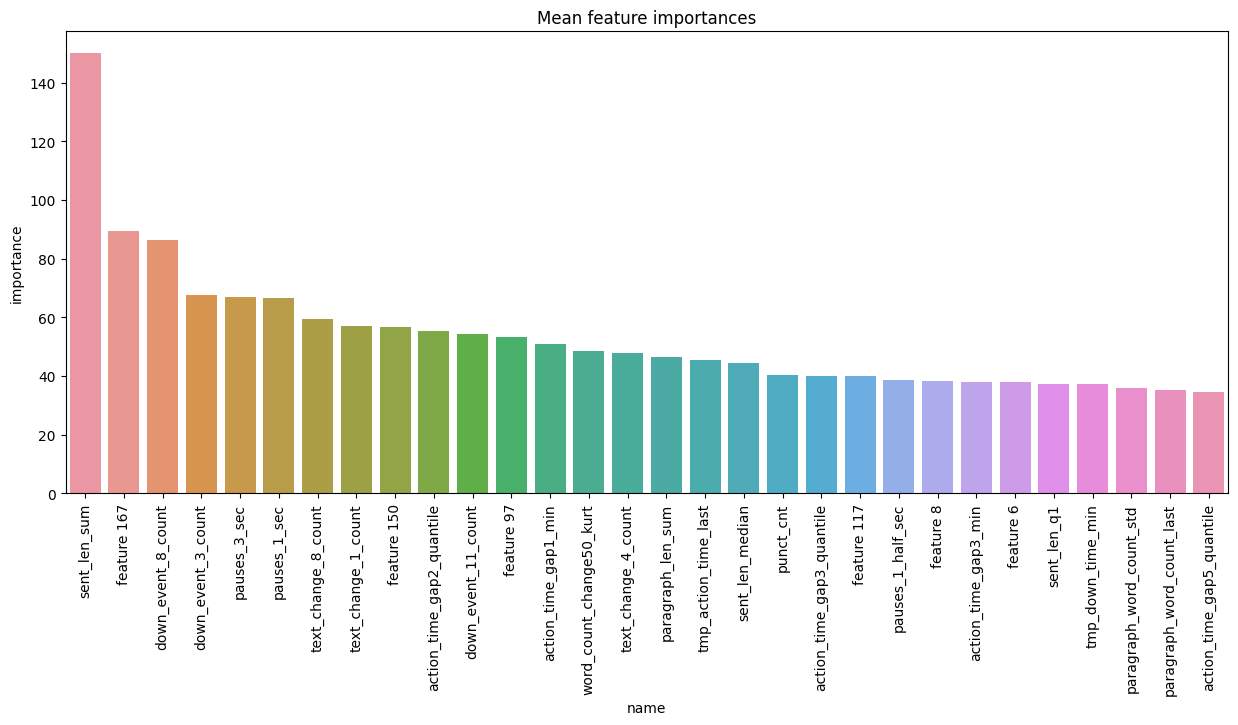

In [75]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(30), x='name', y='importance')
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

In [76]:
test_feats['score'] = np.mean(test_predict_list, axis=0)

In [77]:
sub2 = test_feats[['id', 'score']]

# Writing Quality(fusion_notebook)

In [78]:
import pandas as pd#导入csv文件的库
import numpy as np#进行矩阵运算的库
import polars as pl#和pandas类似,但是处理大型数据集有更好的性能.
#用于对一组元素计数,一个存在默认值的字典,访问不存在的值时抛出的是默认值
from collections import Counter,defaultdict
import re#用于正则表达式提取
from scipy.stats import skew, kurtosis#统计分析和概率分布导入偏度和峰度
import gc#垃圾回收模块

#model
from lightgbm import LGBMRegressor#导入lgbm回归器
from catboost import CatBoostRegressor#catboost回归器
from sklearn.svm import SVR#支持向量回归

#KFold是直接分成k折,StratifiedKFold还要考虑每种类别的占比
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler#用最大值和最小值进行归一化操作(x-min)/(max-min)
from sklearn.impute import SimpleImputer#用于处理数据的缺失值

#设置随机种子,保证模型可以复现
import random
seed=2023
np.random.seed(seed)
random.seed(seed)

import warnings#避免一些可以忽略的报错
warnings.filterwarnings('ignore')#filterwarnings()方法是用于设置警告过滤器的方法，它可以控制警告信息的输出方式和级别。

In [79]:
#交叉验证的折数
num_folds = 10
#需要使用归一化后特征的模型是svr(支持向量回归模型)
model_with_scaled_features = ['svr']
#融合模型的权重
blending_weights = {
    'lgbm': 0.4,
    'catboost': 0.4,
    'svr': 0.2,
}

In [80]:
train_logs=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv")
print(f"len(train_logs):{len(train_logs)}")
train_logs=train_logs.sort_values(by=['id', 'down_time'])
# 重置索引
train_logs = train_logs.reset_index(drop=True)
# 根据'id'列进行分组，并为每个分组添加一个递增的序列
train_logs['event_id'] = train_logs.groupby('id').cumcount() + 1

train_scores=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv")

test_logs=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv")
print(f"len(test_logs):{len(test_logs)}")
test_logs=test_logs.sort_values(by=['id', 'down_time'])
# 重置索引
test_logs = test_logs.reset_index(drop=True)
# 根据'id'列进行分组，并为每个分组添加一个递增的序列
test_logs['event_id'] = test_logs.groupby('id').cumcount() + 1
test_logs.to_csv("test_logs.csv",index=None)

len(train_logs):8405898
len(test_logs):6


In [81]:
#统计‘q’ '.' ‘ ’的一个函数.
def getEssays(df):
    #获取传入的df的这几列.
    textInputDf = df[['id', 'activity', 'cursor_position', 'text_change']]
    #取出activity不等于'Nonproduction'的那些数据
    textInputDf = textInputDf[textInputDf.activity != 'Nonproduction']
    #统计每个id的出现次数,不排序
    valCountsArr = textInputDf['id'].value_counts(sort=False).values
    #最后的下标
    lastIndex = 0
    #创建一个新的序列对象.
    essaySeries = pd.Series()
    #index是第几个id,valCount是出现次数
    for index, valCount in enumerate(valCountsArr):
        #取出第i个id的['activity', 'cursor_position', 'text_change']
        currTextInput = textInputDf[['activity', 'cursor_position', 'text_change']].iloc[lastIndex : lastIndex + valCount]
        #跳到下一个id的index
        lastIndex += valCount
        essayText = ""
        for Input in currTextInput.values:
            #input[0]是这个id的activity
            if Input[0] == 'Replace':
                #text_change按照' => '分开 replaceTxt:[' qqq qqqqq ', ' ']
                replaceTxt = Input[2].split(' => ')#应该是A=>B的操作
                #input[1]是鼠标位置,是一个数字 鼠标位置-len()
                #这是一个字符串的转换操作,由replaceTxt[0]转成replaceTxt[1] 
                essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] +essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
                continue
            if Input[0] == 'Paste':#粘贴
                #print(f"input[2]:{Input[2]}") #input[2]:qqqqqqqqqqq 
                essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
                continue
            if Input[0] == 'Remove/Cut':#删除剪切 在Input[1]的位置删除Input[2]
                essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
                continue
            #如果是Move from
            if "M" in Input[0]:
                #[284, 292] To [282, 290] 把[284, 292]这8行移动到[282,290]
                croppedTxt = Input[0][10:]
                #from和to的4个数字分开.
                splitTxt = croppedTxt.split(' To ')
                valueArr = [item.split(', ') for item in splitTxt]
                moveData = (int(valueArr[0][0][1:]), 
                            int(valueArr[0][1][:-1]), 
                            int(valueArr[1][0][1:]), 
                            int(valueArr[1][1][:-1]))
                #行号不相等,如果相等,等于什么都没有做
                if moveData[0] != moveData[2]:
                    #行号小于 
                    if moveData[0] < moveData[2]:
                        essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] +\
                        essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                    #行号大于
                    else:
                        essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] +\
                        essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
                continue
            #相当于是个check    
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
        #对应id对应论文
        essaySeries[index] = essayText
    #id
    essaySeries.index =  textInputDf['id'].unique()
    return pd.DataFrame(essaySeries, columns=['essay']).reset_index().rename(columns={"index":'id'})

In [82]:
#获取数据中第25%的数值
def q1(x):
    return x.quantile(0.25)
#获取数据中第75%的数值
def q3(x):
    return x.quantile(0.75)
AGGREGATIONS = ['count', 'mean', 'std', 'min', 'max', 'first', 'last', 'sem', q1, 'median', q3, 'skew', kurtosis, 'sum']

#将论文转成单词
def split_essays_into_words(df):
    essay_df = df
    #对空格,\n,句号问号感叹号进行匹配,得到一个拆分后的列表.
    essay_df['word'] = essay_df['essay'].apply(lambda x: re.split(' |\\n|\\.|\\?|\\!',x))
    # essay1 [1,2,3] essay2[4,5] ->5行 essay1 1  // essay1 2 // essay1 3 // essay2 1 // essay2 2
    essay_df = essay_df.explode('word')
    #求出每个单词的长度
    essay_df['word_len'] = essay_df['word'].apply(lambda x: len(x))
    #去掉单词长度为0的数据
    essay_df = essay_df[essay_df['word_len'] != 0]
    return essay_df

#计算word_len的统计学变量,并计算>=word_len的词数
def compute_word_aggregations(word_df):
    #根据id计算单词长度的统计学变量
    word_agg_df = word_df[['id','word_len']].groupby(['id']).agg(AGGREGATIONS)
    #比如('mean','word_len')->'mean_word_len'
    word_agg_df.columns = ['_'.join(x) for x in word_agg_df.columns]
    word_agg_df['id'] = word_agg_df.index
    for word_l in [5, 6, 7, 8, 9, 10, 11, 12]:
        #ge 就是Latex里>=的符号,筛选出word_len>=word_l的行,根据id进行统计,提取每个计数的第0行
        word_agg_df[f'word_len_ge_{word_l}_count'] = word_df[word_df['word_len'] >= word_l].groupby(['id']).count().iloc[:, 0]
        #如果有缺失值就填充为0
        word_agg_df[f'word_len_ge_{word_l}_count'] = word_agg_df[f'word_len_ge_{word_l}_count'].fillna(0)
    #重置索引
    word_agg_df = word_agg_df.reset_index(drop=True)
    return word_agg_df

#将传入的论文df转成句子
def split_essays_into_sentences(df):
    essay_df = df#传入的df就是论文的df
    #对句子按照. ? !进行拆分. 得到一个拆分后的列表.
    essay_df['sent'] = essay_df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    # essay1 [1,2,3] essay2[4,5] ->5行 essay1 1  // essay1 2 // essay1 3 // essay2 1 // essay2 2
    essay_df = essay_df.explode('sent')
    #将换行符'\n'变成空白字符 strip 去除行头和行尾的空白字符.
    essay_df['sent'] = essay_df['sent'].apply(lambda x: x.replace('\n','').strip())
    #统计一下每个句子的长度 
    essay_df['sent_len'] = essay_df['sent'].apply(lambda x: len(x))
    #求一下每个句子单词的个数.
    essay_df['sent_word_count'] = essay_df['sent'].apply(lambda x: len(x.split(' ')))
    #去掉那些句子长度为0的数据
    essay_df = essay_df[essay_df.sent_len!=0].reset_index(drop=True)
    return essay_df

def compute_sentence_aggregations(df):
    #统计句子长度的统计学变量和每个句子词数的统计学变量
    sent_agg_df = pd.concat(
        [df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    )
    #比如('mean','sent_len')->'mean_sent_len'
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index

    # New features intoduced here: https://www.kaggle.com/code/mcpenguin/writing-processes-to-quality-baseline-v2
    for sent_l in [50, 60, 75, 100]:
        #ge 就是Latex里>=的符号,筛选出sent_len>=sent_l的行,根据id进行统计,提取每个计数的第0行
        sent_agg_df[f'sent_len_ge_{sent_l}_count'] = df[df['sent_len'] >= sent_l].groupby(['id']).count().iloc[:, 0]
        #如果有缺失值就填充为0
        sent_agg_df[f'sent_len_ge_{sent_l}_count'] = sent_agg_df[f'sent_len_ge_{sent_l}_count'].fillna(0)
    #重置索引
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    #一句话里词的个数的count,其实就是有多少句话,也就是sent_len的count.重复了,故去掉.
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    #sent_len_count其实就是有多少句话,故rename.
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df

#将论文根据换行符划分为段落.(每段有多少句话为什么没有统计?)
def split_essays_into_paragraphs(df):
    essay_df = df
    #按照'\n'划分成段落 [1,2,3]
    essay_df['paragraph'] = essay_df['essay'].apply(lambda x: x.split('\n'))
    #[论文1 [段落1 段落2,……]->[论文1 段落1 // 论文1 段落2]
    essay_df = essay_df.explode('paragraph')
    #统计段落的长度
    essay_df['paragraph_len'] = essay_df['paragraph'].apply(lambda x: len(x)) 
    #统计每个段落的词数
    essay_df['paragraph_word_count'] = essay_df['paragraph'].apply(lambda x: len(x.split(' ')))
    #将段落长度为0的数据去掉.
    essay_df = essay_df[essay_df.paragraph_len!=0].reset_index(drop=True)
    return essay_df

#对段落的长度和词数用统计学变量,和上面句子的代码一致.
def compute_paragraph_aggregations(df):
    paragraph_agg_df = pd.concat(
        [df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    ) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

In [83]:
print("train_essays")
train_essays = pd.read_csv('/kaggle/input/writing-quality-challenge-constructed-essays/train_essays_fast.csv')
print("train_word_agg_df")
train_word_agg_df = compute_word_aggregations(split_essays_into_words(train_essays))
print("train_sent_agg_df")
train_sent_agg_df = compute_sentence_aggregations(split_essays_into_sentences(train_essays))
print("train_paragraph_agg_df")
train_paragraph_agg_df = compute_paragraph_aggregations(split_essays_into_paragraphs(train_essays))
print("test_essays")
test_essays = getEssays(test_logs)
test_essays_copy=test_essays.copy()
print("test_word_agg_df")
test_word_agg_df = compute_word_aggregations(split_essays_into_words(test_essays))
print("test_sent_agg_df")
test_sent_agg_df = compute_sentence_aggregations(split_essays_into_sentences(test_essays))
print("test_paragraph_agg_df")
test_paragraph_agg_df = compute_paragraph_aggregations(split_essays_into_paragraphs(test_essays))

train_essays
train_word_agg_df
train_sent_agg_df
train_paragraph_agg_df
test_essays
test_word_agg_df
test_sent_agg_df
test_paragraph_agg_df


In [84]:
class Preprocessor:#数据预处理的一个类
    
    def __init__(self):
        
        self.activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste','Move From']#这是activity的一列
        self.events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 
              'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']#down_event中选出一些重要的
        self.text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']#text_change中选出一些重要的
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']#down_event中的一些标点符号
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]#滞后项
        
        #这里是用于存储每个activity的idf值
        self.idf = defaultdict(float)#创建了一个float类型的字典,如果访问不存在,默认值为0.0
    
    #统计df对象中activity的count
    def activity_counts(self, df):
        #对每个id的所有activity组合成一个列表
        tmp_df = df.groupby('id').agg({'activity': list}).reset_index()
        #创建一个空列表
        ret = list()
        for li in tmp_df['activity'].values:#取出一个人的activity列表
            items = list(Counter(li).items())#转成[(activity1:count1),(activity2:count2),……]
            di = dict()#一个空字典
            #每个activity初始化为0
            for k in self.activities:
                di[k] = 0
            #统计每个activity的count
            for item in items:
                k, v = item[0], item[1]#k:activity v:count
                if k in di:
                    di[k] = v
            #加上这个人的每个activity的count
            ret.append(di)
        #转成pandas类型
        ret = pd.DataFrame(ret)
        #给表格的每列换个名字
        cols = [f'activity_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        #每列元素求和,文章中出现的总次数
        cnts = ret.sum(1)

        #前面是词袋模型,这里转成tf-idf模型
        for col in cols:#activity_i_count
            if col in self.idf.keys():#字典里如果已经有这个key了
                idf = self.idf[col]
            else:#不在这个字典里
                #计算idf=log(数据量/(某列和+1))
                idf = np.log(df.shape[0] / (ret[col].sum() + 1))
                self.idf[col] = idf#将col的idf加入字典
            #ret[col] / cnts :给定文章的次数/在文章中出现的总次数,为什么取log再加1不知道
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret#tf-idf

    #这个是event的tf-idf模型,这里可能有down_event和up_event,故colname单独设置
    def event_counts(self, df, colname):
        tmp_df = df.groupby('id').agg({colname: list}).reset_index()
        ret = list()
        for li in tmp_df[colname].values:
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    #text_change的tf-idf模型
    def text_change_counts(self, df):
        tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
        ret = list()
        for li in tmp_df['text_change'].values:
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf
            
        return ret
    #统计标点之类的出现的次数,不过这次是直接将它们相加做统计的.(可能这样比tf-idf好?)
    def match_punctuations(self, df):
        tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
        ret = list()
        for li in tmp_df['down_event'].values:
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:#只要在这张表里,就相加
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
        return ret


    def get_input_words(self, df):
        #~是取反的布尔值 取出text_change 中不包含 => 且不是Nochange的
        tmp_df = df[(~df['text_change'].str.contains('=>'))&(df['text_change'] != 'NoChange')].reset_index(drop=True)
        #在drop掉包含 => 和Nochange之后 按id打包成列表
        tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
        #将列表连接成一个整体
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
        #用正则表达式子匹配一个或者多个'q'字符
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
        #统计len,也就是统计text_change中有多少个有q的字符
        tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
        #求均值,方差,最大值,取到np.nan就设置为0
        tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop(['text_change'], axis=1, inplace=True)
        return tmp_df
    
    #对df做特征工程
    def make_feats(self, df):
        
        print("Starting to engineer features")
        #创建一个只有id一列的表格
        feats = pd.DataFrame({'id': df['id'].unique().tolist()})
        #做时序上的特征工程
        print("Engineering time data")
        for gap in self.gaps:
            print(f"-> for gap {gap}")
            #利用up_time的shift创造action_time_gap
            df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
            df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
        df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)

        #对cursor_position做特征工程,这个就是自己-自己
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"-> for gap {gap}")
            df[f'cursor_position_shift{gap}'] = df.groupby('id')['cursor_position'].shift(gap)
            df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[f'cursor_position_shift{gap}']
            #取了绝对值,鼠标向前移动也是移动了.
            df[f'cursor_position_abs_change{gap}'] = np.abs(df[f'cursor_position_change{gap}'])
        df.drop(columns=[f'cursor_position_shift{gap}' for gap in self.gaps], inplace=True)

        #对word_count做类似的特征工程,词数减少也是移动了.
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"-> for gap {gap}")
            df[f'word_count_shift{gap}'] = df.groupby('id')['word_count'].shift(gap)
            df[f'word_count_change{gap}'] = df['word_count'] - df[f'word_count_shift{gap}']
            df[f'word_count_abs_change{gap}'] = np.abs(df[f'word_count_change{gap}'])
        df.drop(columns=[f'word_count_shift{gap}' for gap in self.gaps], inplace=True)
        
        print("Engineering statistical summaries for features")
        #需要对哪些特征做哪些统计变量,这些都是大佬统计好的,就不做修改了.
        feats_stat = [
            ('event_id', ['max']),
            ('down_time',['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum']),
            ('up_time',['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum']),
            ('action_time', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt,'last', 'first','median']),
            ('activity', ['nunique']),
            ('down_event', ['nunique']),
            ('up_event', ['nunique']),
            ('text_change', ['nunique']),
            ('cursor_position', ['nunique', 'max', 'quantile', 'sem', 'mean', 'std', 'min','last', 'first',  'median', 'sum']),
            ('word_count', ['nunique', 'max', 'quantile', 'sem', 'mean', 'std', 'min', 'last', 'first','median', 'sum'])]
        #滞后特征的统计变量用for循环进行添加
        for gap in self.gaps:
            feats_stat.extend([
                (f'action_time_gap{gap}', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'cursor_position_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'word_count_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt])
            ])
        
        pbar = feats_stat
        for item in pbar:
            colname, methods = item[0], item[1]#取出某列特征和需要进行的统计学的量'max'
            for method in methods:
                #转成能放入agg的方法
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                #添加到feats里.
                tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method_name}'})
                feats = feats.merge(tmp_df, on='id', how='left')

        #调用方法求activity的tf-idf
        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        #调用方法求down_event和up_event的tf-idf
        print("Engineering event counts data")
        tmp_df = self.event_counts(df, 'down_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, 'up_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # input words
        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on='id', how='left')

        # compare feats
        print("Engineering ratios data")
        feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
        feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
        feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
        #休息时间的占比
        feats['idle_time_ratio'] = feats['action_time_gap1_sum'] / feats['up_time_max']
        
        print("Done!")
        return feats

preprocessor = Preprocessor()
print("Engineering features for training data")

train_feats = preprocessor.make_feats(train_logs)
print("-"*25)
print("Engineering features for test data")
test_feats = preprocessor.make_feats(test_logs)

Engineering features for training data
Starting to engineer features
Engineering time data
-> for gap 1
-> for gap 2
-> for gap 3
-> for gap 5
-> for gap 10
-> for gap 20
-> for gap 50
-> for gap 100
Engineering cursor position data
-> for gap 1
-> for gap 2
-> for gap 3
-> for gap 5
-> for gap 10
-> for gap 20
-> for gap 50
-> for gap 100
Engineering word count data
-> for gap 1
-> for gap 2
-> for gap 3
-> for gap 5
-> for gap 10
-> for gap 20
-> for gap 50
-> for gap 100
Engineering statistical summaries for features
Engineering activity counts data
Engineering event counts data
Engineering text change counts data
Engineering punctuation counts data
Engineering input words data
Engineering ratios data
Done!
-------------------------
Engineering features for test data
Starting to engineer features
Engineering time data
-> for gap 1
-> for gap 2
-> for gap 3
-> for gap 5
-> for gap 10
-> for gap 20
-> for gap 50
-> for gap 100
Engineering cursor position data
-> for gap 1
-> for gap 2

In [85]:
data = []

for logs in [train_logs, test_logs]:
    #up_time向后移动并且用down_time填充缺失的位置
    logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
    #(down_time减上一个时刻的up_time) /1000是单位转换
    logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000

    #按照id打包time_diff
    group = logs.groupby('id')['time_diff']
    #延迟时间的max,min,median
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    #down_time的first /1000是做单位转换吧
    initial_pause = logs.groupby('id')['down_time'].first() / 1000
    #分层次求和
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x <= 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x <= 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x <= 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x <= 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(pd.DataFrame({
        'id': logs['id'].unique(),
         #延迟
        'largest_lantency': largest_lantency,
        'smallest_lantency': smallest_lantency,
        'median_lantency': median_lantency,
        'initial_pause': initial_pause,
        'pauses_half_sec': pauses_half_sec,
        'pauses_1_sec': pauses_1_sec,
        'pauses_1_half_sec': pauses_1_half_sec,
        'pauses_2_sec': pauses_2_sec,
        'pauses_3_sec': pauses_3_sec,
    }).reset_index(drop=True))

train_eD592674, test_eD592674 = data

gc.collect()#手动触发垃圾回收,强制回收由垃圾回收器标记为未使用的内存

train_feats = train_feats.merge(train_eD592674, on='id', how='left')
test_feats = test_feats.merge(test_eD592674, on='id', how='left')
train_feats = train_feats.merge(train_scores, on='id', how='left')

In [86]:
#将论文的特征加上
train_feats=train_feats.merge(train_word_agg_df,on='id', how='left')
train_feats=train_feats.merge(train_sent_agg_df,on='id', how='left')
train_feats=train_feats.merge(train_paragraph_agg_df,on='id', how='left')

#将论文的特征加上
test_feats=test_feats.merge(test_word_agg_df,on='id', how='left')
test_feats=test_feats.merge(test_sent_agg_df,on='id', how='left')
test_feats=test_feats.merge(test_paragraph_agg_df,on='id', how='left')

In [87]:
#找到只有唯一值的列,删掉
keys=train_feats.keys().values
unique_cols=[key for key in keys if train_feats[key].nunique()<2]
print(f"unique_cols:{unique_cols}")
train_feats = train_feats.drop(columns=unique_cols)
test_feats = test_feats.drop(columns=unique_cols)

unique_cols:['cursor_position_min', 'word_count_change1_quantile', 'word_count_change2_quantile', 'activity_5_count', 'smallest_lantency']


In [88]:
#这里创建了lgbm,cat,SVR模型
def make_model():
    
    #大佬找好的参数,这里不做改动
    params = {'reg_alpha': 0.007678095440286993, 
               'reg_lambda': 0.34230534302168353, 
               'colsample_bytree': 0.627061253588415, 
               'subsample': 0.854942238828458, 
               'learning_rate': 0.038697981947473245, 
               'num_leaves': 22, 
               'max_depth': 37, 
               'min_child_samples': 18,
               'random_state': seed,
               'n_estimators': 150,
               "objective": "regression",
               "metric": "rmse",
               'force_col_wise': True,
               "verbosity": 0,
              }
    
    model1 = LGBMRegressor(**params)
    
    model2 = CatBoostRegressor(iterations=1000,
                                 learning_rate=0.1,
                                 depth=6,
                                 eval_metric='RMSE',
                                 random_seed = seed,
                                 bagging_temperature = 0.2,
                                 od_type='Iter',
                                 metric_period = 50,
                                 od_wait=20,
                                 verbose=False)
    
    model3 = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    
    models = []
    models.append((model1, 'lgbm'))
    models.append((model2, 'catboost'))
    models.append((model3, 'svr'))
    
    return models

In [89]:
best_features =train_feats.drop(['score'],axis=1).keys().values 
X_y = pd.merge(train_feats[best_features], train_scores, on='id', how='left')

#将里面正无穷和负无穷的值替换成缺失值
X_y.replace([np.inf, -np.inf], np.nan, inplace=True)

features = X_y.iloc[:,1:-1]#特征是除了score和label的其他列
target = X_y.iloc[:,-1]#target是score

#评估指标是RMSE
def RMSE(y_true,y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

models_and_errors_dict = {}

for model, model_type in make_model():
    
    oof_pred=np.zeros((len(features)))
        
    #10折交叉验证
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed + num_folds)

    for fold, indexes in enumerate(kf.split(features), start=1):

        # Get train and test indexes
        train_index, test_index = indexes

        print(f'--- Fold #{fold} ---')       

        # Split data into train and test sets
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        #因为有的模型需要归一化,不能动到原始数据
        X_train_copy, X_test_copy = X_train.copy(), X_test.copy()

        print(f'Training a {model_type} model on fold {fold}')

        #如果是需要归一化的模型
        if model_type in model_with_scaled_features:
            #用平均值来填充缺失值
            imputer = SimpleImputer(strategy='mean')
            X_train_imputed = imputer.fit_transform(X_train.copy())
            X_test_imputed = imputer.transform(X_test.copy())
            #然后用最大最小值来归一化,归一化的范围为[-1,1]
            scaler = MinMaxScaler(feature_range=(-1, 1))
            X_train_scaled = scaler.fit_transform(X_train_imputed)
            X_test_scaled = scaler.transform(X_test_imputed)
            #使用归一化好的数据
            X_train_copy = X_train_scaled
            X_test_copy = X_test_scaled
        #模型的训练
        if model_type == 'lgb':
            #早停200次,只考虑第一个度量指标,不显示训练日志
            early_stopping_callback = LGBMRegressor.early_stopping(200, first_metric_only=True, verbose=False)
            verbose_callback = LGBMRegressor.log_evaluation(100)#每隔100次打印一次训练日志

            model.fit(X_train_copy, y_train, eval_set=[(X_test_copy, y_test)],  
                      callbacks=[early_stopping_callback, verbose_callback],)
        else:
            model.fit(X_train_copy, y_train)

        #做预测
        y_hat = model.predict(X_test_copy)
        
        oof_pred[test_index]=y_hat
        #计算RMSE
        rmse = RMSE(y_test, y_hat)
        print(f'RMSE: {rmse} on fold {fold}')

        #在字典里没有就创建一个
        if model_type not in models_and_errors_dict:
            models_and_errors_dict[model_type] = []
        #如果是需要归一化的模型,除了保存模型和损失,还需要将填充缺失值和归一化的模型保存
        if model_type in model_with_scaled_features:
            models_and_errors_dict[model_type].append((model, rmse, imputer, scaler,oof_pred))
        else:
            models_and_errors_dict[model_type].append((model, rmse, None, None,oof_pred))  

--- Fold #1 ---
Training a lgbm model on fold 1
RMSE: 0.5732040865152326 on fold 1
--- Fold #2 ---
Training a lgbm model on fold 2
RMSE: 0.6053315922891468 on fold 2
--- Fold #3 ---
Training a lgbm model on fold 3
RMSE: 0.5816994464525892 on fold 3
--- Fold #4 ---
Training a lgbm model on fold 4
RMSE: 0.6322910338559691 on fold 4
--- Fold #5 ---
Training a lgbm model on fold 5
RMSE: 0.6674363524541856 on fold 5
--- Fold #6 ---
Training a lgbm model on fold 6
RMSE: 0.653121896279151 on fold 6
--- Fold #7 ---
Training a lgbm model on fold 7
RMSE: 0.6345597645536013 on fold 7
--- Fold #8 ---
Training a lgbm model on fold 8
RMSE: 0.5844092524453968 on fold 8
--- Fold #9 ---
Training a lgbm model on fold 9
RMSE: 0.5639393605364796 on fold 9
--- Fold #10 ---
Training a lgbm model on fold 10
RMSE: 0.6725593553767791 on fold 10
--- Fold #1 ---
Training a catboost model on fold 1
RMSE: 0.5999151025757493 on fold 1
--- Fold #2 ---
Training a catboost model on fold 2
RMSE: 0.6264515855104754 on f

In [90]:
lgb_oof_pred=models_and_errors_dict['lgbm'][9][4]
cat_oof_pred=models_and_errors_dict['catboost'][9][4]
svr_oof_pred=models_and_errors_dict['svr'][9][4]
margin=1000
target=target.values
current_RMSE=RMSE(target,(lgb_oof_pred+cat_oof_pred+svr_oof_pred)/3)
best_i=0
best_j=0
for i in range(0,margin):
    for j in range(0,margin-i):
        #k=1000-i-j
        blend_oof_pred=(i*lgb_oof_pred+j*cat_oof_pred+(margin-i-j)*svr_oof_pred)/margin
        if RMSE(target,blend_oof_pred)<current_RMSE:
            print(f"current_RMSE:{current_RMSE}")
            current_RMSE=RMSE(target,blend_oof_pred)
            best_i=i
            best_j=j
#找到最好的参数之后
blending_weights['lgbm']=best_i/margin
blending_weights['catboost']=best_j/margin
blending_weights['svr']=(margin-best_i-best_j)/margin
print(f"blending_weights:{blending_weights}")

current_RMSE:0.614210440054201
current_RMSE:0.6142099794978685
current_RMSE:0.6142087427357589
current_RMSE:0.6142076078997665
current_RMSE:0.6142065749904562
current_RMSE:0.6142056440083423
current_RMSE:0.6142048149538883
current_RMSE:0.614204087827507
current_RMSE:0.6142034626295604
current_RMSE:0.6142029393603595
current_RMSE:0.6142025180201652
current_RMSE:0.6142021986091871
current_RMSE:0.6142019811275843
current_RMSE:0.6142018655754647
current_RMSE:0.6142018519528863
current_RMSE:0.6142015324327432
current_RMSE:0.61420025859723
current_RMSE:0.6141990866890966
current_RMSE:0.6141980167089265
current_RMSE:0.6141970486572522
current_RMSE:0.6141961825345558
current_RMSE:0.6141954183412685
current_RMSE:0.6141947560777706
current_RMSE:0.6141941957443922
current_RMSE:0.6141937373414118
current_RMSE:0.6141933808690581
current_RMSE:0.6141931263275081
current_RMSE:0.614192973716889
current_RMSE:0.6141929230372764
current_RMSE:0.6141918267189407
current_RMSE:0.6141906177377428
current_RMSE:

In [91]:
y_hats = dict()

#设置submission_df,id和score
submission_df = pd.DataFrame(test_feats['id'])
submission_df['score'] = 3.5#如果报错,将预测结果设置为3.5

#取出test_feats中所有列
X_unseen = test_feats.copy()[best_features]
#去掉id这一列.
X_unseen.drop(columns=['id'], inplace=True)
#测试集中把np.inf和-np.inf代替为np.nan
X_unseen.replace([np.inf, -np.inf], np.nan, inplace=True)

for model_name, model_info in models_and_errors_dict.items():
    print(f'\n--- {model_name} ---\n')
    
    #复制是因为有的要归一化
    X_unseen_copy = X_unseen.copy()
    y_hats[model_name] = []#某个model的预测结果

    for ix, (trained_model, error, imputer, scaler,oof_pred) in enumerate(model_info, start=1):
        print(f"Using model {ix} with error {error}")

        #如果需要归一化的话,也就是支持向量回归模型
        if model_name in model_with_scaled_features:
            #先填充缺失值,再用归一化
            X_unseen_imputed = imputer.transform(X_unseen_copy)
            X_unseen_scaled = scaler.transform(X_unseen_imputed)
            #得到预测结果
            y_hats[model_name].append(trained_model.predict(X_unseen_scaled))
        else:#如果是树模型直接得到预测结果
            y_hats[model_name].append(trained_model.predict(X_unseen_copy))
    #如果有值的话,求平均,赋值给submission_df
    if y_hats[model_name]:
        y_hat_avg = np.mean(y_hats[model_name], axis=0)
        submission_df['score_' + model_name] = y_hat_avg
    print("Done.")
print("blending")
blended_score=np.zeros((len(test_essays_copy)))
for k, v in blending_weights.items():
    blended_score += submission_df['score_' + k] * v
print(f"blended_score:{blended_score}")


--- lgbm ---

Using model 1 with error 0.5732040865152326
Using model 2 with error 0.6053315922891468
Using model 3 with error 0.5816994464525892
Using model 4 with error 0.6322910338559691
Using model 5 with error 0.6674363524541856
Using model 6 with error 0.653121896279151
Using model 7 with error 0.6345597645536013
Using model 8 with error 0.5844092524453968
Using model 9 with error 0.5639393605364796
Using model 10 with error 0.6725593553767791
Done.

--- catboost ---

Using model 1 with error 0.5999151025757493
Using model 2 with error 0.6264515855104754
Using model 3 with error 0.5822730346458717
Using model 4 with error 0.6606537932896053
Using model 5 with error 0.6696240611648159
Using model 6 with error 0.6726787719020365
Using model 7 with error 0.6308800695783247
Using model 8 with error 0.6061958504534815
Using model 9 with error 0.5803663811164711
Using model 10 with error 0.6771085443277639
Done.

--- svr ---

Using model 1 with error 0.5967965374879748
Using model 2 w

In [92]:
#数值型变量的几列
num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']
activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
text_changes = ['q', ' ', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']

#df表格的colname列统计values的count.
def count_by_values(df, colname, values):
    #maintain_order=True保持原有顺序
    fts = df.select(pl.col('id').unique(maintain_order=True))
    for i, value in enumerate(values):
        #根据每个id判断colname是不是value并统计个数,rename成colname_i_cnt
        tmp_df = df.group_by('id').agg(pl.col(colname).is_in([value]).sum().alias(f'{colname}_{i}_cnt'))
        #加上这个特征
        fts  = fts.join(tmp_df, on='id', how='left') 
    return fts

def dev_feats(df):
    
    print("< Count by values features >")
    
    #统计activity,text_change,down_event,up_event这几个类别型变量的count
    feats = count_by_values(df, 'activity', activities)
    feats = feats.join(count_by_values(df, 'text_change', text_changes), on='id', how='left') 
    feats = feats.join(count_by_values(df, 'down_event', events), on='id', how='left') 
    feats = feats.join(count_by_values(df, 'up_event', events), on='id', how='left') 

    print("< Input words stats features >")
    #不含有'=>'且有变化的行
    temp = df.filter((~pl.col('text_change').str.contains('=>')) & (pl.col('text_change') != 'NoChange'))
    #按照id将text_change连接成一个长字符串,然后匹配'q+'的字符串
    temp = temp.group_by('id').agg(pl.col('text_change').str.concat('').str.extract_all(r'q+'))
    #统计输入的词数,词长度的均值,最大值,方差,中位数,偏斜度.
    temp = temp.with_columns(input_word_count = pl.col('text_change').list.lengths(),
                             input_word_length_mean = pl.col('text_change').apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_max = pl.col('text_change').apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_std = pl.col('text_change').apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_median = pl.col('text_change').apply(lambda x: np.median([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_skew = pl.col('text_change').apply(lambda x: skew([len(i) for i in x] if len(x) > 0 else 0)))
    #将text_change这列去掉,加入特征.
    temp = temp.drop('text_change')
    feats = feats.join(temp, on='id', how='left') 

    print("< Numerical columns features >")

    #对action_time求和,对数值型变量求均值,方差,中位数,最小值,最大值,50%的数字
    temp = df.group_by("id").agg(pl.sum('action_time').suffix('_sum'), pl.mean(num_cols).suffix('_mean'), pl.std(num_cols).suffix('_std'),
                                 pl.median(num_cols).suffix('_median'), pl.min(num_cols).suffix('_min'), pl.max(num_cols).suffix('_max'),
                                 pl.quantile(num_cols, 0.5).suffix('_quantile'))
    feats = feats.join(temp, on='id', how='left') 


    print("< Categorical columns features >")
    #类别型变量求了n_unique,加入特征.
    temp  = df.group_by("id").agg(pl.n_unique(['activity', 'down_event', 'up_event', 'text_change']))
    feats = feats.join(temp, on='id', how='left') 

    print("< Idle time features >")
    #这里就是论文中的特征.(https://files.eric.ed.gov/fulltext/ED592674.pdf)
    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.group_by("id").agg(inter_key_largest_lantency = pl.max('time_diff'),
                                   inter_key_median_lantency = pl.median('time_diff'),
                                   mean_pause_time = pl.mean('time_diff'),
                                   std_pause_time = pl.std('time_diff'),
                                   total_pause_time = pl.sum('time_diff'),
                                   pauses_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 0.5) & (pl.col('time_diff') < 1)).count(),
                                   pauses_1_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1) & (pl.col('time_diff') < 1.5)).count(),
                                   pauses_1_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1.5) & (pl.col('time_diff') < 2)).count(),
                                   pauses_2_sec = pl.col('time_diff').filter((pl.col('time_diff') > 2) & (pl.col('time_diff') < 3)).count(),
                                   pauses_3_sec = pl.col('time_diff').filter(pl.col('time_diff') > 3).count(),)
    feats = feats.join(temp, on='id', how='left') 
    
    print("< P-bursts features >")
    #找到df中activity为‘Input’和‘Remove/cut’的行,并且是time_diff<2的行
    temp = df.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
    temp = temp.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
    temp = temp.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.with_columns(pl.col('time_diff')<2)
    #然后统计连续出现的个数的(统计学变量)
    temp = temp.with_columns(pl.when(pl.col("time_diff") & pl.col("time_diff").is_last()).then(pl.count()).over(pl.col("time_diff").rle_id()).alias('P-bursts'))
    temp = temp.drop_nulls()#删除包含缺失值的行
    temp = temp.group_by("id").agg(pl.mean('P-bursts').suffix('_mean'), pl.std('P-bursts').suffix('_std'), pl.count('P-bursts').suffix('_count'),
                                   pl.median('P-bursts').suffix('_median'), pl.max('P-bursts').suffix('_max'),
                                   pl.first('P-bursts').suffix('_first'), pl.last('P-bursts').suffix('_last'))
    feats = feats.join(temp, on='id', how='left') 

    print("< R-bursts features >")
    #取出数据中为'Remove/cut'
    temp = df.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
    temp = temp.with_columns(pl.col('activity').is_in(['Remove/Cut']))
    #统计'Remove/cut'连续出现的次数(的统计学变量)
    temp = temp.with_columns(pl.when(pl.col("activity") & pl.col("activity").is_last()).then(pl.count()).over(pl.col("activity").rle_id()).alias('R-bursts'))
    temp = temp.drop_nulls()#删除包含缺失值的行
    temp = temp.group_by("id").agg(pl.mean('R-bursts').suffix('_mean'), pl.std('R-bursts').suffix('_std'), 
                                   pl.median('R-bursts').suffix('_median'), pl.max('R-bursts').suffix('_max'),
                                   pl.first('R-bursts').suffix('_first'), pl.last('R-bursts').suffix('_last'))
    feats = feats.join(temp, on='id', how='left')
    
    return feats

In [93]:
AGGREGATIONS = ['count', 'mean', 'min', 'max', 'first', 'last', q1, 'median', q3, 'sum']

def word_feats(df):
    essay_df = df
    df['word'] = df['essay'].apply(lambda x: re.split(' |\\n|\\.|\\?|\\!',x))
    df = df.explode('word')
    df['word_len'] = df['word'].apply(lambda x: len(x))
    df = df[df['word_len'] != 0]

    word_agg_df = df[['id','word_len']].groupby(['id']).agg(AGGREGATIONS)
    word_agg_df.columns = ['_'.join(x) for x in word_agg_df.columns]
    word_agg_df['id'] = word_agg_df.index
    word_agg_df = word_agg_df.reset_index(drop=True)
    return word_agg_df


def sent_feats(df):
    df['sent'] = df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    df = df.explode('sent')
    df['sent'] = df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    df['sent_len'] = df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    df['sent_word_count'] = df['sent'].apply(lambda x: len(x.split(' ')))
    df = df[df.sent_len!=0].reset_index(drop=True)

    sent_agg_df = pd.concat([df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), 
                             df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1)
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df

def parag_feats(df):
    df['paragraph'] = df['essay'].apply(lambda x: x.split('\n'))
    df = df.explode('paragraph')
    # Number of characters in paragraphs
    df['paragraph_len'] = df['paragraph'].apply(lambda x: len(x)) 
    # Number of words in paragraphs
    df['paragraph_word_count'] = df['paragraph'].apply(lambda x: len(x.split(' ')))
    df = df[df.paragraph_len!=0].reset_index(drop=True)
    
    paragraph_agg_df = pd.concat([df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), 
                                  df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

#论文的长度除以(‘Input’和‘Remove/Cut’)的按键个数.
def product_to_keys(logs, essays):
    essays['product_len'] = essays.essay.str.len()#论文的长度
    #logs中每个id ‘Input’和‘Remove/Cut’的数据
    tmp_df = logs[logs.activity.isin(['Input', 'Remove/Cut'])].groupby(['id']).agg({'activity': 'count'}).reset_index().rename(columns={'activity': 'keys_pressed'})
    essays = essays.merge(tmp_df, on='id', how='left')
    #论文的长度除以(‘Input’和‘Remove/Cut’)的按键个数.
    essays['product_to_keys'] = essays['product_len'] / essays['keys_pressed']
    return essays[['id', 'product_to_keys']]
#统计每秒有几个['Input', 'Remove/Cut']的行为.
def get_keys_pressed_per_second(logs):
    #logs中为['Input', 'Remove/Cut']的event_id的个数
    temp_df = logs[logs['activity'].isin(['Input', 'Remove/Cut'])].groupby(['id']).agg(keys_pressed=('event_id', 'count')).reset_index()
    #每个id最小的down_time和最大的up_time
    temp_df_2 = logs.groupby(['id']).agg(min_down_time=('down_time', 'min'), max_up_time=('up_time', 'max')).reset_index()
    #按照id融合在一起
    temp_df = temp_df.merge(temp_df_2, on='id', how='left')
    #每秒有几个event_id
    temp_df['keys_per_second'] = temp_df['keys_pressed'] / ((temp_df['max_up_time'] - temp_df['min_down_time']) / 1000)
    return temp_df[['id', 'keys_per_second']]

In [94]:
#传入训练数据dataX和datay,model,测试数据test_X
#就是一个简单的k折交叉验证,不过模型只有1个训练5次.训练完就得到测试集的预测结果.
def evaluate(data_x, data_y, model, random_state=seed, n_splits=5, test_x=None):
    #StratifiedKFold还要考虑每种类别的占比
    skf    = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    test_y = np.zeros((len(test_x), n_splits))#5折的预测结果
    for i, (train_idx, valid_idx) in enumerate(skf.split(data_x, data_y.astype(str))):
        train_x = data_x.iloc[train_idx]
        train_y = data_y[train_idx]
        valid_x = data_x.iloc[valid_idx]
        valid_y = data_y[valid_idx]
        model.fit(train_x, train_y)
        test_y[:, i] = model.predict(test_x)
    return np.mean(test_y, axis=1)


train_logs    = pl.scan_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
train_feats   = dev_feats(train_logs)
train_feats   = train_feats.collect().to_pandas()

print('< Essay Reconstruction >')
train_logs             = train_logs.collect().to_pandas()
train_essays           = pd.read_csv('/kaggle/input/writing-quality-challenge-constructed-essays/train_essays_fast.csv')
train_feats            = train_feats.merge(word_feats(train_essays), on='id', how='left')
train_feats            = train_feats.merge(sent_feats(train_essays), on='id', how='left')
train_feats            = train_feats.merge(parag_feats(train_essays), on='id', how='left')
train_feats            = train_feats.merge(get_keys_pressed_per_second(train_logs), on='id', how='left')
train_feats            = train_feats.merge(product_to_keys(train_logs, train_essays), on='id', how='left')

#找到只有唯一值的列,删掉
keys=train_feats.keys().values
unique_cols=[key for key in keys if train_feats[key].nunique()<2]
print(f"unique_cols:{unique_cols}")
train_feats = train_feats.drop(columns=unique_cols)

print('< Mapping >')
train_scores   = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')
data           = train_feats.merge(train_scores, on='id', how='left')
x              = data.drop(['id', 'score'], axis=1)
y              = data['score'].values

print(f'Number of features: {len(x.columns)}')

print('< Testing Data >')
test_logs   = pl.scan_csv('/kaggle/working/test_logs.csv')
test_feats  = dev_feats(test_logs)
test_feats  = test_feats.collect().to_pandas()

test_logs             = test_logs.collect().to_pandas()
test_essays           = test_essays_copy
test_feats            = test_feats.merge(word_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(sent_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(parag_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(get_keys_pressed_per_second(test_logs), on='id', how='left')
test_feats            = test_feats.merge(product_to_keys(test_logs, test_essays), on='id', how='left')

test_feats = test_feats.drop(columns=unique_cols)

test_ids = test_feats['id'].values
testin_x = test_feats.drop(['id'], axis=1)

print('< Learning and Evaluation >')
lgbm_params = {'n_estimators': 1024,
         'learning_rate': 0.006,
         'metric': 'rmse',
         'random_state': seed,
         'force_col_wise': True,
         'verbosity': 0,}
solution = LGBMRegressor(**lgbm_params)
y_pred_lgb   = evaluate(x.copy(), y.copy(), solution, test_x=testin_x.copy()) 
y_pred_lgb

< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >
< Essay Reconstruction >
unique_cols:['cursor_position_min']
< Mapping >
Number of features: 164
< Testing Data >
< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >
< Learning and Evaluation >


array([1.22775611, 1.20103044, 1.21616856])

In [95]:
y_pred = blended_score*0.4+ y_pred_lgb*0.6#将两种预测结果进行一个加权融合

sub3 = pd.DataFrame({'id': test_ids, 'score': y_pred})
sub3.head()

,id,score
0,0000aaaa,1.453569
1,2222bbbb,1.421195
2,4444cccc,1.429121


# Submission

In [96]:
clean_memory()

In [97]:
sub1.rename(columns={'score': 'score_1'}, inplace=True)
sub2.rename(columns={'score': 'score_2'}, inplace=True)
sub3.rename(columns={'score': 'score_3'}, inplace=True)

submission = pd.merge(sub1, sub2, on='id')
submission = pd.merge(submission, sub3, on='id')

submission['score'] = (submission['score_1']*0.2 +  #LGBM + NN (Weighted search for "print(W)")
                       submission['score_2']*0.3 +  #LGBM Public
                       submission['score_3']*0.5)   #Fusion

submission_final = submission[['id', 'score']]

In [98]:
submission_final.to_csv('submission.csv', index=False)

In [99]:
submission_final

,id,score
0,0000aaaa,1.508856
1,2222bbbb,1.352377
2,4444cccc,1.349697
